# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from numpy import array as npArr
import matplotlib.pyplot as plt
import pandas as pd
from workspace_utils import keep_awake
from PIL import Image
#numpy needed by functions came with the project instruction
import numpy as np
import json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ]),
    'vldTest': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform = data_transforms['train']),
    'vld': datasets.ImageFolder(valid_dir, transform = data_transforms['vldTest']),
    'test': datasets.ImageFolder(test_dir, transform = data_transforms['vldTest'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
batchSize = 128

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = batchSize, shuffle = True),
    'vld': torch.utils.data.DataLoader(image_datasets['vld'], batch_size = batchSize),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size = batchSize)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
#a few functions to be used repeatedly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ce = nn.CrossEntropyLoss()

cpName = 'cp.pth'

def buildResnet152(fcs):
    mdl = models.resnet152(pretrained = True)

    # Freeze parameters so we don't backprop through them
    for param in mdl.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(fcs)
    
    mdl.fc = classifier
    
    return mdl

def vldTest(mdl, dataLdr):
    '''
        runs a forward pass on the data loader
        
        params:
            mdl(pytorch model): the model will be used to make predictions
            dataLdr(pytorch data loader): the data loader is expected to have images and labels
                so this function should only be used on validation or testing since you must have labels
                on the data you want to prediction
        returns:
            lossPerB(list): containing validation or test loss from each batch
            probsPerB(list): containing softmax probabilities for each image each batch
                each list item is a batch which has rows and columns
                rows corresponds to images, and each column represents the probability for a class
            corrects(list): list of 1s and 0s indicating 1 as correct prediction, and 0 as incorrect
    '''
    lossPerB = []
    probsPerB = []
    corrects = []
    
    # turn off gradients
    with torch.no_grad():
        # set model to evaluation mode so that dropout doesn't get applied
        mdl.eval()
        
        # validation pass here
        for imgs, lbls in dataLdr:
            # Move input and label tensors to the GPU
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            logits = mdl(imgs)
            
            loss = ce(logits, lbls)
            
            probs = F.softmax(logits, dim = 1)
            
            clss = probs.topk(1, dim = 1)[1]
            
            corrects.extend(clss == lbls.view(*clss.shape))
            
            #add up all the vld loss for each epoch
            lossPerB.append(loss.item())
            #add up all the probs
            probsPerB.append(probs)
            
    return lossPerB, probsPerB, corrects

def ldMdl(f):
    #extra arguments for loading with cpu
    cp = torch.load(f, map_location = lambda storage, loc:storage)
    
    mdl = buildResnet152(cp['fcs'])
    
    mdl.load_state_dict(cp['sd'])
    
    mdl.bs = cp['bs']
    mdl.lr = cp['lr']
    mdl.optmzr = cp['optmzr']
    mdl.epochs = cp['epochs']
    mdl.clsNames = cp['clsNames']
    mdl.lowestVldLoss = cp['lvl']
    
    return mdl

In [6]:
# TODO: Build and train your network
fcs = OrderedDict([
    ('fc1', nn.Linear(2048, 2048 * 2)),
    ('relu1', nn.ReLU()),
    ('do1', nn.Dropout(.2)),

    ('fc2', nn.Linear(2048 * 2, 2048 * 4)),
    ('relu2', nn.ReLU()),
    ('do2', nn.Dropout(.2)),

    ('fc3', nn.Linear(2048 * 4, 2048 * 2)),
    ('relu3', nn.ReLU()),
    ('do3', nn.Dropout(.2)),

    ('fc4', nn.Linear(2048 * 2, 2048)),
    ('relu4', nn.ReLU()),
    ('do4', nn.Dropout(.2)),

    ('fc5', nn.Linear(2048, 2048)),
    ('relu5', nn.ReLU()),
    ('do5', nn.Dropout(.2)),
    
    ('fc6', nn.Linear(2048, 2048)),
    ('relu6', nn.ReLU()),
    ('do6', nn.Dropout(.2)),
    
    ('fc7', nn.Linear(2048, 2048)),
    ('relu7', nn.ReLU()),
    ('do7', nn.Dropout(.2)),
    
    ('fc8', nn.Linear(2048, 2048)),
    ('relu8', nn.ReLU()),
    ('do8', nn.Dropout(.2)),

    ('opt', nn.Linear(2048, 102))
])    
    
mdl = buildResnet152(fcs)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 84980980.63it/s]


In [7]:
#run this if continue training from saved model
mdl = ldMdl(cpName)

In [9]:
#train
# Only train the classifier parameters, feature parameters are frozen
lr = 0.001

optmzr = optim.Adam(mdl.fc.parameters(), lr = lr)  

mdl.to(device)

#the graph implies that more training can improve further
#but on 2nd training nothing improved
epochs = 100

lossHist_train, lossHist_vld = [], []

#keep the state_dict for the best model
#if after new training the vld loss never beat the saved model
#then the original saved model would just be saved again
try:
    lowestVldLoss = mdl.lowestVldLoss
except AttributeError:
    lowestVldLoss = 99.9

bestSd = mdl.state_dict()

for e in keep_awake(range(epochs)):
    #reset loss for each epoch
    losses_train, losses_vld = [], []
    
    mdl.train()
    
    for imgs, lbls in dataloaders['train']:
        # Move input and label tensors to the GPU
        imgs, lbls = imgs.to(device), lbls.to(device)

        optmzr.zero_grad()

        logits = mdl.forward(imgs)
        loss = ce(logits, lbls)
        loss.backward()
        optmzr.step()

        #add up all the train loss for the epoch
        losses_train.append(loss.item())
        
    #vld pass
    losses_vld, probs, crcts = vldTest(mdl, dataloaders['vld'])

    #avg loss per batch for the epoch
    loss_train = npArr(losses_train).mean()
    loss_vld = npArr(losses_vld).mean()
    accuracy_vld = npArr(crcts).mean()
    
    #add loss to history
    lossHist_train.append({
        'epoch': e,
        'loss': loss_train
    })
    
    lossHist_vld.append({
        'epoch': e,
        'loss': loss_vld
    })
    
    #keep track of the lowest vld loss
    if loss_vld < lowestVldLoss:
        mdl.lowestVldLoss = lowestVldLoss = loss_vld
        
        #keep state_dict of the lowest vld loss model
        bestSd = mdl.state_dict()
    
    #print out each epoch as to get a sense of progress
    print('epoch: {}, train loss: {}, vld loss: {}, vld accuracy: {}'.format(e, loss_train, loss_vld, accuracy_vld))
    
#save mdl
torch.save(
    {
        'fcs': fcs,
        'bs': batchSize,
        'lr': lr,
        'sd_optmzr': optmzr.state_dict(),
        'epoch': epochs
        'sd': bestSd,
        'clsNames': cat_to_name,
        'lvl': lowestVldLoss
    },
    cpName
)

#plot loss history
plt.errorbar(data = pd.DataFrame(lossHist_train), x = 'epoch', y = 'loss')
plt.errorbar(data = pd.DataFrame(lossHist_vld), x = 'epoch', y = 'loss')

epoch: 0, train loss: 1.1967866237346942, vld loss: 0.6777333872658866, vld accuracy: 0.8581907090464548
epoch: 1, train loss: 1.146212522800152, vld loss: 0.7091664437736783, vld accuracy: 0.8679706601466992
epoch: 2, train loss: 1.3343508266485655, vld loss: 1.3593539595603943, vld accuracy: 0.7224938875305623
epoch: 3, train loss: 1.4963974356651306, vld loss: 0.936096795967647, vld accuracy: 0.8227383863080685
epoch: 4, train loss: 1.2990601945381899, vld loss: 0.7275712404932294, vld accuracy: 0.8679706601466992
epoch: 5, train loss: 1.2352135341901045, vld loss: 0.6738848175321307, vld accuracy: 0.8520782396088019
epoch: 6, train loss: 1.3200793048510184, vld loss: 0.676614984869957, vld accuracy: 0.8667481662591687
epoch: 7, train loss: 1.3518921847526844, vld loss: 0.6815744872604098, vld accuracy: 0.8704156479217604
epoch: 8, train loss: 1.2174272651855762, vld loss: 0.615705206990242, vld accuracy: 0.8728606356968215
epoch: 9, train loss: 1.141667719070728, vld loss: 0.620779

KeyboardInterrupt: 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [10]:
# TODO: Do validation on the test set
#load best model for testing
mdl = ldMdl(cpName)

print(mdl.lowestVldLoss)

mdl.to(device)

crcts_test = vldTest(mdl, dataloaders['test'])[2]

#measure accuracy
print('accuracy on test set: {}'.format(npArr(crcts_test).mean()))

0.616308620998
accuracy on test set: 0.8522588522588522


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint
torch.save(
    {
        'fcs': fcs,
        'bs': batchSize,
        'lr': lr,
        'sd_optmzr': optmzr.state_dict(),
        'epoch': epochs
        'sd': bestSd,
        'clsNames': cat_to_name,
        'lvl': lowestVldLoss
    },
    cpName
)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def ldMdl(f):
    #extra arguments for loading with cpu
    cp = torch.load(f, map_location = lambda storage, loc:storage)
    
    mdl = buildResnet152(cp['fcs'])
    
    mdl.load_state_dict(cp['sd'])
    
    mdl.bs = cp['bs']
    mdl.lr = cp['lr']
    mdl.optmzr = cp['optmzr']
    mdl.epochs = cp['epochs']
    mdl.clsNames = cp['clsNames']
    mdl.lowestVldLoss = cp['lvl']
    
    return mdl

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [53]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    #resize
    #shortest side = 256
    w, h = image.width, image.height
    
    ss = min(w, h)
    
    dlta_ratio = 256 / ss
    
    #modified in place
    image.thumbnail((w * dlta_ratio, h * dlta_ratio))
    
    #center crop
    wc, hc = image.width / 2, image.height / 2
    
    top = hc - 112
    lft = wc - 112
    rgt = wc + 112
    btm = hc + 112
    
    img_crop = image.crop((lft, top, rgt, btm))
    
    #normalize
    img_np = npArr(img_crop)
    
    #we need to convert int arr to float arr first
    #because we want the result to be float arr
    img_np = img_np.astype('float64') / 255
    
    img_np = (img_np - npArr([0.485, 0.456, 0.406])) / npArr([0.229, 0.224, 0.225])
    
    img_t = img_np.transpose((2, 0, 1))
    
    return img_t

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [63]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    img = Image.open(image_path)
    
    #apply transforms
    imgData = process_image(img)
    
    #to tensor
    #needs to be float tensor
    img = torch.from_numpy(imgData).float()
    
    #get probs
    with torch.no_grad():
        model.eval()
        
        #img to device
        img.to(device)
        
        #since we only have 1 image, the batch dimension is missing
        #which the model requires (why this is not explained)
        #so we need to use unsqueeze to add the batch dimension at position 0
        #I don't understand why this was never explained
        #and I had to debug forever to find out
        logits = model(img.unsqueeze_(0))
            
        probs = F.softmax(logits, dim = 1)
    
    return probs.topk(topk, dim = 1)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [23]:
#make sure to load mdl first before testing
mdl = ldMdl(cpName)

testLdr = iter(dataloaders['test'])

In [37]:
#the labels in the test set starts at 0
#so in theory the labels should go from 0 to 101
#where 0 corresponds to 1, and 101 corresponds to 102
#however, I've found this not to be the case when lable is 73
#it should correspond to 74 (rose)
#but it's not a rose, and it does come from the 73 folder
#which makes no sense if label 0 comes from folder 1, then label 73 should come from folder 74
for imgs, lbls in dataloaders['test']:
    print(lbls)
    
#after printing out all labels and number of images for each label,
#then inspecting the test folder
#I realized that 0 corresponds to 1
# and 1 corresponds to 10
# 2 corresponds to 100
#because that's how the folders are arranged in the system
#so 0, 1, 2 = 1, 10, 100
#that's going to make translating numbers to flower names incredibly difficult
#again, why was this never explained

tensor([  0,   0,   0,   0,   0,   1,   1,   1,   2,   2,   2,   2,
          2,   2,   2,   2,   3,   3,   3,   3,   4,   4,   4,   4,
          4,   4,   5,   5,   5,   5,   5,   5,   5,   5,   5,   6,
          6,   6,   6,   6,   6,   6,   6,   6,   7,   7,   7,   7,
          7,   7,   8,   8,   8,   9,   9,   9,   9,  10,  10,  10,
         11,  11,  11,  11,  11,  11,  11,  11,  11,  12,  12,  12,
         12,  12,  12,  13,  13,  13,  13,  13,  13,  13,  14,  14,
         14,  14,  14,  15,  15,  15,  16,  16,  17,  17,  17,  17,
         18,  18,  18,  18,  18,  18,  18,  19,  19,  20,  20,  20,
         20,  20,  21,  21,  21,  21,  21,  22,  22,  22,  23,  23,
         23,  23,  23,  23,  24,  24,  24,  24])
tensor([ 24,  24,  24,  24,  24,  25,  25,  26,  26,  26,  26,  26,
         26,  26,  26,  26,  26,  26,  26,  26,  26,  27,  27,  28,
         28,  28,  28,  28,  28,  29,  29,  29,  29,  29,  29,  29,
         29,  30,  30,  30,  30,  30,  31,  31,  31,  31,  31,  31,

set()

In [66]:
#we are going to attempt to sort the clsNames dictionary in the same order that image folders are arranged in the system
#eg, 1, 10, 100, 101, 102, 11, 12
sortedClsNames = sorted(
    mdl.clsNames.items(), 
    key = lambda itm: 
        itm[0]
)

print(sortedClsNames)

[('1', 'pink primrose'), ('10', 'globe thistle'), ('100', 'blanket flower'), ('101', 'trumpet creeper'), ('102', 'blackberry lily'), ('11', 'snapdragon'), ('12', "colt's foot"), ('13', 'king protea'), ('14', 'spear thistle'), ('15', 'yellow iris'), ('16', 'globe-flower'), ('17', 'purple coneflower'), ('18', 'peruvian lily'), ('19', 'balloon flower'), ('2', 'hard-leaved pocket orchid'), ('20', 'giant white arum lily'), ('21', 'fire lily'), ('22', 'pincushion flower'), ('23', 'fritillary'), ('24', 'red ginger'), ('25', 'grape hyacinth'), ('26', 'corn poppy'), ('27', 'prince of wales feathers'), ('28', 'stemless gentian'), ('29', 'artichoke'), ('3', 'canterbury bells'), ('30', 'sweet william'), ('31', 'carnation'), ('32', 'garden phlox'), ('33', 'love in the mist'), ('34', 'mexican aster'), ('35', 'alpine sea holly'), ('36', 'ruby-lipped cattleya'), ('37', 'cape flower'), ('38', 'great masterwort'), ('39', 'siam tulip'), ('4', 'sweet pea'), ('40', 'lenten rose'), ('41', 'barbeton daisy'),

tensor(73)
water lily


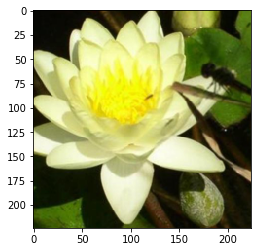

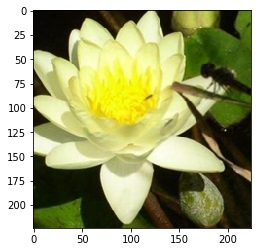

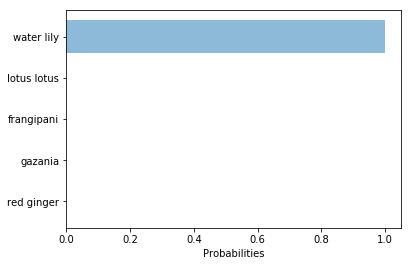

In [77]:
# TODO: Display an image along with the top 5 classes
#get img from next batch of test data
ldr = iter(dataloaders['test'])

for i in range(4):
    ldr.next()

testData = ldr.next()

img = testData[0][0]
lbl = testData[1][0]

print(lbl)

#access sorted clsNames by using lbl as index
lbl = sortedClsNames[lbl.item()][1]
print(lbl)
#processed with pytorch
imshow(img, title = lbl)

#images path for this image
ip = 'flowers/test/73/image_00337.jpg'

img2 = Image.open(ip)
    
#apply transforms
img2 = process_image(img2)

#to tensor
#needs to be float tensor
img2 = torch.from_numpy(img2).float()

#processed with custom function
imshow(img2)

probs, clss = predict(ip, mdl)

clss = [sortedClsNames[i][1] for i in clss.tolist()[0]]
probs = probs.tolist()[0]

fig, ax = plt.subplots()

y_pos = np.arange(len(clss))

plt.barh(y_pos, probs, align='center', alpha=0.5)
plt.yticks(y_pos, clss)
plt.xlabel('Probabilities')

ax.invert_yaxis()

plt.show()